### 🚜 ***Predicting the Sale Price of Bulldozers using Machine Learning***

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

Since we're trying to predict a number, this kind of problem is known as a `regression problem`.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

The techniques used in here have been inspired and adapted from the [fast.ai machine learning course](https://course18.fast.ai/ml).



#### ***`1. Problem Definition`***


For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,
> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

#### ***`2. Data`***

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **`Train.csv`** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the ***`target`*** variable).
2. **`Valid.csv`** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as ***`Train.csv`***).
3. **`Test.csv`** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the    ***`SalePrice`*** attribute, as this is what we'll be trying to predict).

#### ***`3. Evaluation`***

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

#### ***`4. Features`***

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **`data dictionary`**


First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition..

In [332]:
# Timestamp
import datetime

print(f"Notebook last run (end-to-end) : {datetime.datetime.now()}")


# To supress the warnings until the end of the code
import warnings
warnings.filterwarnings("ignore")

Notebook last run (end-to-end) : 2023-08-31 19:26:57.068950


##### Importing the data and preparing it for modelling

In [333]:
# import data analysis tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [334]:
# Importing the data

df = pd.read_csv("Data\TrainAndValid.csv",low_memory=False)


In [335]:
# No parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [336]:
# Reading the data_dictionary and converting it into dataframe...
data = pd.read_excel("data/Data Dictionary.xlsx")


# Creating feature Dictionary from the above dataframe..
features_dict = dict(zip(data["Variable"], data["Description"]))
features_dict

{'SalesID': '  unique identifier of a particular sale of a machine at auction',
 'MachineID': '  identifier for a particular machine;  machines may have multiple sales',
 'ModelID': '  identifier for a unique machine model (i.e. fiModelDesc)',
 'datasource': '  source of the sale record;  some sources are more diligent about reporting attributes of the machine than others.  Note that a particular datasource may report on multiple auctioneerIDs.',
 'auctioneerID': '  identifier of a particular auctioneer, i.e. company that sold the machine at auction.  Not the same as datasource.',
 'YearMade': '  year of manufacturer of the Machine',
 'MachineHoursCurrentMeter': '  current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale',
 'UsageBand': "  value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel;  e.g. 'Low' means this machine has less hours given it's lifes

In [337]:
# Let's see the date of the sale of the machines ...as it is a Time Series data
df["saledate"]

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

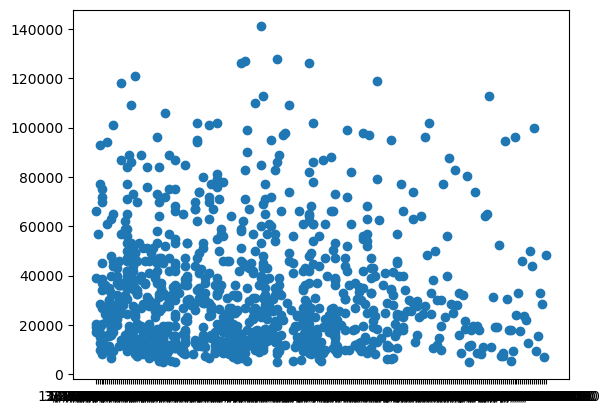

In [338]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

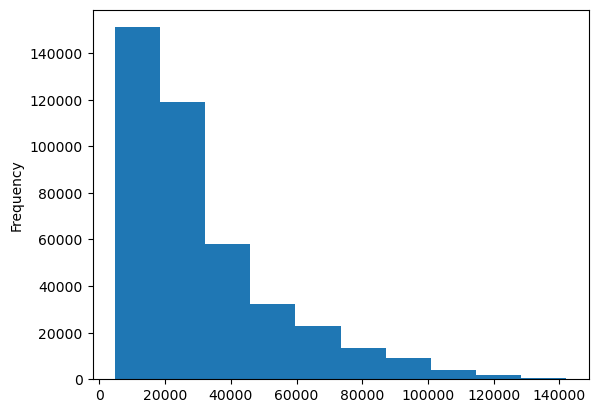

In [339]:
df.SalePrice.plot.hist()

##### ***`Parsing Dates`***

When working with time series data, it's a good idea to make sure any date data is the format of a [datetime](https://docs.python.org/3/library/datetime.html) object 
(a Python data type which encodes specific information about dates).

In [340]:
df = pd.read_csv("Data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [341]:
# With parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

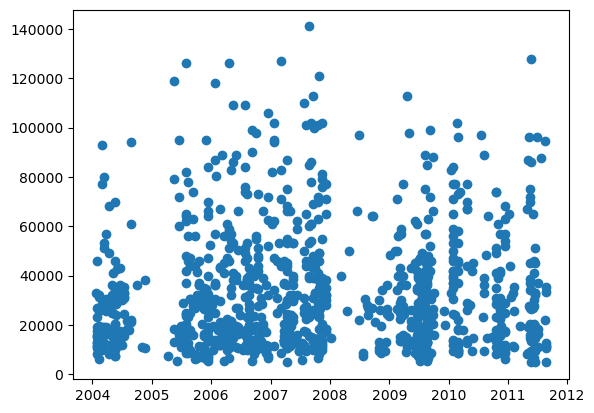

In [342]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

In [343]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [344]:
# As our dataframe has too many features...that's why using df.head()...will skip some features while displaying...that's why we take 
# transpose
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [345]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

##### ***`Sort DataFrame by SaleDate`***

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [346]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"],
               inplace=True,
               ascending=True)

df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

##### ***`Make a Copy of the original DataFrame`***

As we are manipulating the data...it's good to do it in the copy of the dataframe....and keep the original one untouched...

In [347]:
# Making the copy
df_tmp = df.copy()

##### ***`Add Datetime paramters for Saledate column`***


> Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using read_csv() and we asked pandas to parse the dates using parase_dates=["saledate"], we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the saledate column.


In [348]:
# This returns any integer between [0,6]...where 0 means = Monday ......and 6 means Sunday
df_tmp.saledate.dt.dayofweek

205615    1
274835    1
141296    1
212552    1
62755     1
         ..
410879    5
412476    5
411927    5
407124    5
409203    5
Name: saledate, Length: 412698, dtype: int64

In [349]:
# A year can have 365 days or 366 days....so it returns which numberred day it is...
df_tmp.saledate.dt.dayofyear

205615     17
274835     31
141296     31
212552     31
62755      31
         ... 
410879    119
412476    119
411927    119
407124    119
409203    119
Name: saledate, Length: 412698, dtype: int64

In [350]:
# Adding Datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear


# Dropping original saledate column
df_tmp.drop("saledate",axis=1,inplace=True)


In [351]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [352]:
# Check different values of "state" column..
df_tmp["state"].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

##### ***`Modelling`***


In [353]:

# This won't work since we've got missing numbers as well as categorical data...

# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs=-1)
# model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp.SalePrice)

In [354]:
# Checking for missing categories and different datatypes
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [355]:
# Checking for missing values..
df_tmp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

##### ***`Convert strings into categories`***

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.
To do this we can use the pandas types API which allows us to interact and manipulate the types of data.

In [356]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [357]:
pd.api.types.is_string_dtype(df_tmp.UsageBand)

True

In [358]:
# Finding all columns that contains strings
x = list(df_tmp.items())
x[0]


for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [359]:
# random_dict.items() applied on a dictionary... makes a list(here it is dict_items) containg tuples...where each tuple represent a key value pair...
# seperated by comma's 
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")


This is a key: key1
This is a value: hello
This is a key: key2
This is a value: world!


In [360]:
# Now to turn all string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        # converts string to category
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [361]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [362]:
df_tmp.UsageBand.dtype

CategoricalDtype(categories=['High', 'Low', 'Medium'], ordered=True)

In [363]:
# Accessing the category of a particular column

# `cat` here is used to access the category functions...just like we have `str` to access string functions...and `dt` to access
# datetime functions....
df_tmp.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [364]:
# Accessing the numerical value assign to the repective category for a particular column
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [365]:
# All of our data has been categorical now and now thus imply we can turn the categories into numbers now...however's it still missing
# values...



# Checking the percantage of missing data in each column

(df_tmp.isnull().sum()/len(df_tmp))*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

>In the format it's in, it's still good to be worked with, let's save it to file and reimport it so we can continue on.

##### ***`Save Processed Data`***

In [366]:
# save preprocessed data
df_tmp.to_csv("../Bulldozer-price-prediction/Data/train_tmp.csv",
              index=False)

In [367]:
# import preprocessed data
df_tmp = pd.read_csv("../Bulldozer-price-prediction/Data/train_tmp.csv",
                     low_memory=False)

df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


##### ***`Fill missing values`***



> ***Filling numerical values first***

we're going to fill any column with missing values with the median of that column

In [368]:
# For printing all numeric columns..
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)
        

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [369]:
# We are filling the missing values with median...because median is more robust than the other paramters like mean...

# Demonstrating why median() is more robust....

hundreds = np.full((1000,),100)
hundreds_billion = np.append(hundreds,1000000000)
np.mean(hundreds),np.mean(hundreds_billion),np.median(hundreds),np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [370]:
# Check for which numeric column has null-value..
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        # If there is null values..in the `content` column
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [371]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        # if there is even a single null value ...this if condition gets true..
        if pd.isnull(content).sum():
            # Add the binary column which tells us if the data was missing or not..it will add a binary value to that particular 
            # value of that column...if `label` has missing data...it assigns  `False` otherwise `True`...it is similar to df.isna()...
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than mean..
            df_tmp[label] = content.fillna(content.median())
            

 

##### **Why add a binary column indicating whether the data was missing or not?**

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [372]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 59 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            73670 non-null   object 
 9   fiModelDesc                          412698 non-null  object 
 10  fiBaseModel                          412698 non-null  object 
 11  fiSecondaryDe

In [373]:
# Checking if there is any numeric-column(s) with null value...
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [374]:
# Checking to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [375]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 59 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            73670 non-null   object 
 9   fiModelDesc                          412698 non-null  object 
 10  fiBaseModel                          412698 non-null  object 
 11  fiSecondaryDe

##### ***`Filling and turning categorical variables to numbers`***

Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [376]:
# Checking columns which are not numeric...
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [377]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a bianry column to indicate if the columns has null values..
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1

In [378]:
df_tmp.UsageBand.value_counts()

0    339028
3     35832
2     25311
1     12527
Name: UsageBand, dtype: int64

In [379]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [380]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [381]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


> Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

In [382]:
# Magic function ...which is used to the execution time of a particular code cell or block 
%%time

from sklearn.ensemble import RandomForestRegressor

# Instatntiate model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp.SalePrice)

CPU times: total: 35min 23s
Wall time: 2min 43s


RandomForestRegressor(n_jobs=-1)

In [383]:
# Scoring the model
model.score(df_tmp.drop("SalePrice",axis=1),df_tmp.SalePrice)

0.9875704631896162

Why is this metric not reliable?

* This metric is not reliable because...we have evaluated the model on the same dataset in which we have trained(fitted) it...

* So we will evaluate it on the unseen data..

##### ***`Splitting data into train/validation sets`*** 

In [407]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


 **According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates.**

 **This makes sense since we're working on a time series problem.**

 **E.g. using past events to try and predict future events.**

 **Knowing this, randomly splitting our data into train and test sets using something like train_test_split() wouldn't work.**

 **Instead, we split our data into training, validation and test sets using the date each sample occured.**

 **In our case:**

*  ***`Training` = all samples up until 2011***
*  ***`Valid` = all samples form January 1, 2012 - April 30, 2012***
*  ***`Test` = all samples from May 1, 2012 - November 2012***


 **For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/posts/2017-11-13-validation-sets.html) by Rachel Thomas.**

In [415]:
df_tmp.saleYear.value_counts()
# We observe the maximum year is 2012 and rest of all are lesser than it...

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [421]:
# Split data into training and validation

# Now as we have imported only the training dataset...that means...all the sales of 2012 will be in validation set...
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_train),len(df_val)

(401125, 11573)

In [419]:
# Splitting data into X and y
X_train, y_train = df_train.drop("SalePrice",axis=1),df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice",axis=1),df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

##### ***`Building an Evaluation Function`***

According to Kaggle for the Bluebook for Bulldozers competition, the [evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

***`RMSLE`*** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. ***`MAE`*** (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

In [425]:
# Create evaluation function (Root mean Square log error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test,y_preds):
    return np.sqrt(mean_squared_log_error(y_test,y_preds))



# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    
    return scores

##### ***`Testing our Model on a subset (to tune the hyperparameters)`***

- Retraing an entire model would take far too long to continuing experimenting as fast as we want to.
- So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.
- If you're experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [426]:
# This will take too long...

# %% time
# # Retrain a model on training data...
# model.fit(X_train,y_train)
# show_scores(model)

In [427]:
len(X_train)

401125

In [428]:
# Let's alter the number of samples each n_estimator in the RandomForestRegressor see's using the max_samples parameter.

# Change max_samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)



##### 
* Setting max_samples to 10000 means every n_estimator (default 100) in our RandomForestRegressor will only see 10000 random samples from our DataFrame instead of the entire 400,000.

##### 
* In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [429]:
%%time
# Cutting down the max number of sampleseach tree can see improves training time
model.fit(X_train,y_train)

CPU times: total: 1min 3s
Wall time: 5.69 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [430]:
show_scores(model)

{'Training MAE': 5551.840069404797,
 'Valid MAE': 7170.100919381319,
 'Training RMSLE': 0.2573257660134864,
 'Valid RMSLE': 0.294573751759397,
 'Training R^2': 0.8609611660077416,
 'Valid R^2': 0.832689582486366}

##### ***`Hyperparameter tuning with RandomizedSearchCV`***

You can increase n_iter to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.
Here, we're trying to reduce the amount of time it takes between experiments.

In [440]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters...
rf_grid = {"n_estimators":np.arange(10,100,10),
           "max_depth":[None,3,5,10],
           "min_samples_split":np.arange(2,20,2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features":[0.5,1.0,"sqrt"], # Note: "max_features='auto'" is equivalent to "max_features=1.0", as of Scikit-Learn version 1.1
           "max_samples":[10000]}


rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,  
                              cv=5,
                              verbose=True)


rs_model.fit(X_train,y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 3min 50s
Wall time: 9min 30s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [441]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 1.0,
 'max_depth': None}

In [442]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6042.926623648857,
 'Valid MAE': 7609.8941771265245,
 'Training RMSLE': 0.27518945257157806,
 'Valid RMSLE': 0.3055927914858904,
 'Training R^2': 0.8340995917529583,
 'Valid R^2': 0.8039258941778593}

##### ***`Train a model with the best hyperparameters`***

In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting n_iter to 100 in RandomizedSearchCV) and found the best results came from the ones you see below.

Note: This kind of search on my computer (n_iter = 100) took ~2-hours. So it's kind of a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the max_samples back to its original value.

In [454]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=3,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)


ideal_model.fit(X_train,y_train)

CPU times: total: 14min 4s
Wall time: 1min 4s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3,
                      min_samples_split=14, n_estimators=90, n_jobs=-1,
                      random_state=42)

In [456]:
show_scores(ideal_model)

{'Training MAE': 3127.5350846898527,
 'Valid MAE': 5911.192187602347,
 'Training RMSLE': 0.15403539091594634,
 'Valid RMSLE': 0.24263346747551662,
 'Training R^2': 0.9523281103450383,
 'Valid R^2': 0.8820525062258318}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering *`n_estimators`* since each increase in *`n_estimators`* is basically building another small model.

However, lowering of *`n_estimators`* or altering of other hyperparameters may lead to poorer results.

In [458]:
%%time
fast_model = RandomForestRegressor(n_estimators=30,
                                   min_samples_leaf=1,
                                   max_features = 0.5,
                                   n_jobs=-1)


fast_model.fit(X_train,y_train)

CPU times: total: 4min 41s
Wall time: 24 s


RandomForestRegressor(max_features=0.5, n_estimators=30, n_jobs=-1)

In [460]:
show_scores(fast_model)

{'Training MAE': 1635.6536048751777,
 'Valid MAE': 6029.526547423599,
 'Training RMSLE': 0.0874601226166924,
 'Valid RMSLE': 0.24901128772375203,
 'Training R^2': 0.9864992655740756,
 'Valid R^2': 0.8793356454225889}

##### ***`Make predictions on test data`***


Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [459]:
df_test = pd.read_csv("../Bulldozer-price-prediction/Data/Test.csv",
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [455]:
# Converting test.csv to the format same as training data

##### ***`Preprocessing the test data`***

In [461]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear
    
    
    # Drop Original Values..
    df.drop("saledate",axis=1,inplace=True)
    
    # Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
    
    
        # Turn categorical into numbers
        if not pd.api.types.is_numeric_dtype(content):
            
            df[label+"_is_missing"] = pd.isnull(content)
            
            # We add the +1 because pandas encode missing categories as -1
            df[label] = pd.Categorical(content).codes + 1
            
    
    return df
        

> `Question:` Where would this function break?

In [462]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [463]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [464]:
# Make predictions using the best_model
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


We've found an error and it's because our test dataset (after preprocessing) has 101 columns where as, our training dataset (X_train) has 102 columns (after preprocessing).

In [467]:
# Let's find the missing column(s)

# Set difference
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

***In this case, it's because the test dataset wasn't missing any `auctioneerID` fields.***

***To fix it, we'll add a column to the test dataset called `auctioneerID_is_missing` and fill it with False, since none of the `auctioneerID` fields are missing in the test dataset.***



In [468]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


There's one more step we have to do before we can make predictions on the test data.

And that's to line up the columns (the features) in our test dataset to match the columns in our training dataset.

As in, the order of the columnns in the training dataset, should match the order of the columns in our test dataset.

> ***`Note:`*** As of Scikit-Learn 1.2, the order of columns that were fit on should match the order of columns that are predicted on.

In [469]:
# Match column order from X_train to df_test (to predict on columns, they should be in the same order they were fir on)
df_test = df_test[X_train.columns]


In [476]:
# Now the test dataset column names and column order matches the training dataset, we should be able to make predictions on it using our trained model.

# Making predictions
test_preds = ideal_model.predict(df_test)
test_preds

array([18034.71035502, 16417.5665384 , 48560.3370767 , ...,
       12346.68359095, 15515.82818498, 26042.1780594 ])

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the SalesID and the predicted SalePrice of the bulldozer.

In [473]:
# Create DataFrame compatible with Kaggle submission requirements
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds

df_preds

,SalesID,SalePrice
0,1227829,18034.710355
1,1227844,16417.566538
2,1227847,48560.337077
3,1227848,66475.485926
4,1227863,55296.628825
...,...,...
12452,6643171,40388.537026
12453,6643173,11496.904950
12454,6643184,12346.683591
12455,6643186,15515.828185


In [475]:
# Exporting to csv....
df_preds.to_csv("../Bulldozer-price-prediction/Data/predictions.csv",index=False)

##### ***`Feature Importance`***

In [478]:
ideal_model.feature_importances_

array([3.50281179e-02, 1.72727784e-02, 4.16286038e-02, 1.85962625e-03,
       3.02539025e-03, 2.10608425e-01, 2.91922464e-03, 9.32298186e-04,
       4.66702180e-02, 4.48345111e-02, 5.99773275e-02, 4.66945060e-03,
       1.42710628e-02, 1.57630393e-01, 4.41007930e-02, 5.35604570e-03,
       2.21219684e-03, 2.21370742e-03, 3.93878785e-03, 5.94176160e-02,
       4.83813691e-04, 5.84268661e-05, 9.75329032e-04, 2.91391040e-04,
       1.22256225e-03, 4.78924607e-05, 2.03890447e-03, 7.12970060e-03,
       5.66860584e-04, 1.92908070e-03, 3.88765068e-03, 3.28007872e-03,
       3.78117621e-03, 2.12319290e-03, 4.04497976e-04, 6.59905375e-03,
       7.81369070e-04, 1.18061077e-02, 8.97338954e-04, 2.88102330e-03,
       8.43616594e-04, 9.26971915e-04, 2.28223612e-03, 5.91624969e-04,
       4.02416864e-04, 3.04243774e-04, 2.78601228e-04, 1.69448279e-03,
       9.28142140e-04, 1.71113020e-04, 5.33512336e-04, 7.28859678e-02,
       3.74154466e-03, 5.09772809e-03, 2.60770013e-03, 9.18235312e-03,
      

In [483]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

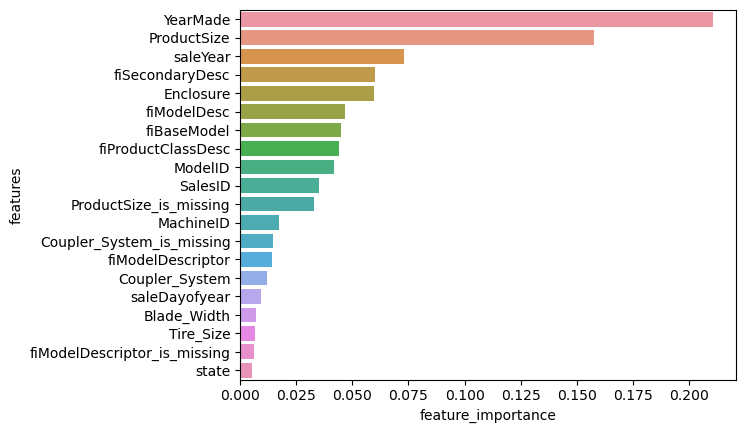

In [484]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [485]:
sum(ideal_model.feature_importances_)

0.9999999999999997

In [486]:
df.ProductSize.isna().sum()

216605

In [487]:
df.ProductSize.value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [488]:
df.Turbocharged.value_counts()

None or Unspecified    77111
Yes                     3985
Name: Turbocharged, dtype: int64

In [489]:
df.Thumb.value_counts()

None or Unspecified    85074
Manual                  9678
Hydraulic               7580
Name: Thumb, dtype: int64

##### ***`Experimenting more`***

Using `catBoost` and `XGBoost`

In [492]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


In [493]:
X_train


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6260687,1074871,4331,149,2.0,1000,0.0,0,3137,1055,...,True,True,True,True,True,True,True,True,False,False
401121,6312170,1812622,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401122,6312727,1811599,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401123,6315051,1858173,17432,149,2.0,2004,0.0,0,3389,1175,...,True,True,True,True,True,True,True,True,True,True


In [494]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

In [495]:
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


##### **` - Modelling`**

In [550]:
# Normal CatBoost Model 
catboost_model = CatBoostRegressor(iterations=500,
                                   learning_rate=0.1,
                                   depth=6,
                                   loss_function ="RMSE")


catboost_model.fit(X_train,y_train)

0:	learn: 21879.6608189	total: 45ms	remaining: 22.4s
1:	learn: 20855.5350807	total: 86.8ms	remaining: 21.6s
2:	learn: 20041.4640931	total: 135ms	remaining: 22.3s
3:	learn: 19289.5327847	total: 176ms	remaining: 21.8s
4:	learn: 18618.4537299	total: 222ms	remaining: 22s
5:	learn: 18048.9546047	total: 262ms	remaining: 21.5s
6:	learn: 17550.9084343	total: 312ms	remaining: 22s
7:	learn: 17091.4945751	total: 362ms	remaining: 22.2s
8:	learn: 16684.0170831	total: 403ms	remaining: 22s
9:	learn: 16348.4033623	total: 436ms	remaining: 21.4s
10:	learn: 16008.5872635	total: 479ms	remaining: 21.3s
11:	learn: 15664.3698419	total: 518ms	remaining: 21.1s
12:	learn: 15382.1135522	total: 557ms	remaining: 20.9s
13:	learn: 15119.2335623	total: 597ms	remaining: 20.7s
14:	learn: 14894.1345177	total: 634ms	remaining: 20.5s
15:	learn: 14684.2810031	total: 673ms	remaining: 20.4s
16:	learn: 14481.9366482	total: 718ms	remaining: 20.4s
17:	learn: 14298.6064687	total: 756ms	remaining: 20.2s
18:	learn: 14097.8237276	t

In [551]:
catboost_model.score(X_train,y_train)

0.8818787228476981

In [598]:
# This will cause error...therefore we will train another model..where we take log of the y_train first..and then fit
mean_squared_log_error(y_train,catboost_model.predict(X_train))

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [552]:
# CatBoost model with log-Scaling
catboost_model_log = CatBoostRegressor(iterations=500,
                                   learning_rate=0.1,
                                   depth=6,
                                   loss_function ="RMSE")

y_train_log = np.log1p(y_train)
catboost_model_log.fit(X_train,y_train_log)

0:	learn: 0.6577818	total: 38.7ms	remaining: 19.3s
1:	learn: 0.6267236	total: 75.2ms	remaining: 18.7s
2:	learn: 0.5995299	total: 111ms	remaining: 18.4s
3:	learn: 0.5756696	total: 150ms	remaining: 18.6s
4:	learn: 0.5557439	total: 183ms	remaining: 18.1s
5:	learn: 0.5357255	total: 220ms	remaining: 18.1s
6:	learn: 0.5199156	total: 256ms	remaining: 18s
7:	learn: 0.5055787	total: 292ms	remaining: 18s
8:	learn: 0.4931807	total: 331ms	remaining: 18s
9:	learn: 0.4788577	total: 371ms	remaining: 18.2s
10:	learn: 0.4687279	total: 412ms	remaining: 18.3s
11:	learn: 0.4575035	total: 455ms	remaining: 18.5s
12:	learn: 0.4477222	total: 503ms	remaining: 18.8s
13:	learn: 0.4401154	total: 539ms	remaining: 18.7s
14:	learn: 0.4319492	total: 581ms	remaining: 18.8s
15:	learn: 0.4241386	total: 622ms	remaining: 18.8s
16:	learn: 0.4177196	total: 658ms	remaining: 18.7s
17:	learn: 0.4113248	total: 700ms	remaining: 18.7s
18:	learn: 0.4057682	total: 738ms	remaining: 18.7s
19:	learn: 0.4005471	total: 775ms	remaining: 

In [553]:
catboost_model_log.score(X_train,y_train_log)

0.887874432051443

In [572]:
# Normal XGBoost Model 
xgboost_model = XGBRegressor(n_estimators = 500,
                             learning_rate=0.1,
                             max_depth=6)

xgboost_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [573]:
xgboost_model.score(X_train,y_train)

0.9112416871612364

In [559]:
# This will cause error...therefore we will train another model..where we take log of the y_train first..and then fit
mean_squared_log_error(y_train,xgboost_model.predict(X_train))

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [556]:
# XGBoost model with log-Scaling
xgboost_model_log = XGBRegressor(n_estimators = 500,
                             learning_rate=0.1,
                             max_depth=6)

y_train_log = np.log1p(y_train)
xgboost_model_log.fit(X_train,y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [557]:
xgboost_model_log.score(X_train,y_train_log)

0.911905536789202

##### ***`Evaluation`***

In [591]:
rmsle_cat = np.sqrt(mean_squared_log_error(y_train, np.expm1(catboost_model_log.predict(X_train))))

rmsle_xg = np.sqrt(mean_squared_log_error(y_train, np.expm1(xgboost_model_log.predict(X_train))))

In [599]:
print(f"Root mean squarred log error on Training data of CatBoosting model is : {rmsle_cat}")
print(f"Root mean squarred log error on Training  data of XGBoosting model is : {rmsle_xg}")

Root mean squarred log error on Training data of CatBoosting model is : 0.23224895073602408
Root mean squarred log error on Training  data of XGBoosting model is : 0.20586178750772402


In [605]:


val_preds_cat = np.expm1(catboost_model_log.predict(X_valid))
msle_val_cat  = mean_squared_log_error(y_valid, val_preds_cat)

print(f"Root mean squarred log error on Validation  data of CatBoosting model is : {np.sqrt(msle_val_cat)}")

Root mean squarred log error on Validation  data of CatBoosting model is : 0.2603258134968974


In [606]:


val_preds_xg = np.expm1(xgboost_model_log.predict(X_valid))
msle_val_xg  = mean_squared_log_error(y_valid, val_preds_xg)

print(f"Root mean squarred log error on Validation  data of XGBoosting model is : {np.sqrt(msle_val_xg)}")



Root mean squarred log error on Validation  data of XGBoosting model is : 0.24146504266109625


##### ***`Predictions`***

In [610]:
# Predictions with normal model

preds_cat = catboost_model.predict(df_test)
preds_xg = xgboost_model.predict(df_test)

preds_cat,preds_xg


(array([17669.01233636, 17796.50961802, 46380.12518093, ...,
        14700.41802529, 20907.83003596, 31520.97093961]),
 array([19732.773, 11152.401, 51808.258, ...,  7752.103, 13058.934,
        25244.092], dtype=float32))

In [609]:
# Predictions with model trained by log-Scaling

preds_cat_log = np.expm1(catboost_model_log.predict(df_test))

preds_xg_log = np.expm1(xgboost_model_log.predict(df_test))


preds_cat_log,preds_xg_log

(array([17232.68392082, 14086.78349082, 45247.90696044, ...,
        13065.00902515, 17227.46524988, 28991.52903914]),
 array([19771.717, 12745.312, 47840.016, ..., 10814.416, 14623.453,
        22247.922], dtype=float32))

##### ***`Plotting and Comparisons`***

In [611]:

df1 = pd.DataFrame()

df1["SalesID"] = df_test["SalesID"]
df1["SalePrice(CatBoost)"] = preds_cat
df1["SalePrice(CatBoost with log Scaling)"] = preds_cat_log
df1["SalePrice(XGBoost)"] = preds_xg
df1["SalePrice(XGBoost with log Scaling)"] = preds_xg_log
df1["SalePrice(Ideal model)"] = test_preds


In [612]:
df1

,SalesID,SalePrice(CatBoost),SalePrice(CatBoost with log Scaling),SalePrice(XGBoost),SalePrice(XGBoost with log Scaling),SalePrice(Ideal model)
0,1227829,17669.012336,17232.683921,19732.773438,19771.716797,18034.710355
1,1227844,17796.509618,14086.783491,11152.401367,12745.311523,16417.566538
2,1227847,46380.125181,45247.906960,51808.257812,47840.015625,48560.337077
3,1227848,68301.351915,67663.617967,62401.269531,60851.179688,66475.485926
4,1227863,42342.894399,33691.124145,42666.175781,40354.851562,55296.628825
...,...,...,...,...,...,...
12452,6643171,45916.849777,40378.756772,37444.468750,38683.500000,40388.537026
12453,6643173,17617.814161,14224.388344,8415.901367,10483.080078,11496.904950
12454,6643184,14700.418025,13065.009025,7752.103027,10814.416016,12346.683591
12455,6643186,20907.830036,17227.465250,13058.933594,14623.453125,15515.828185


In [613]:
df1.columns

Index(['SalesID', 'SalePrice(CatBoost)',
       'SalePrice(CatBoost with log Scaling)', 'SalePrice(XGBoost)',
       'SalePrice(XGBoost with log Scaling)', 'SalePrice(Ideal model)'],
      dtype='object')

In [622]:
len(df1)

12457

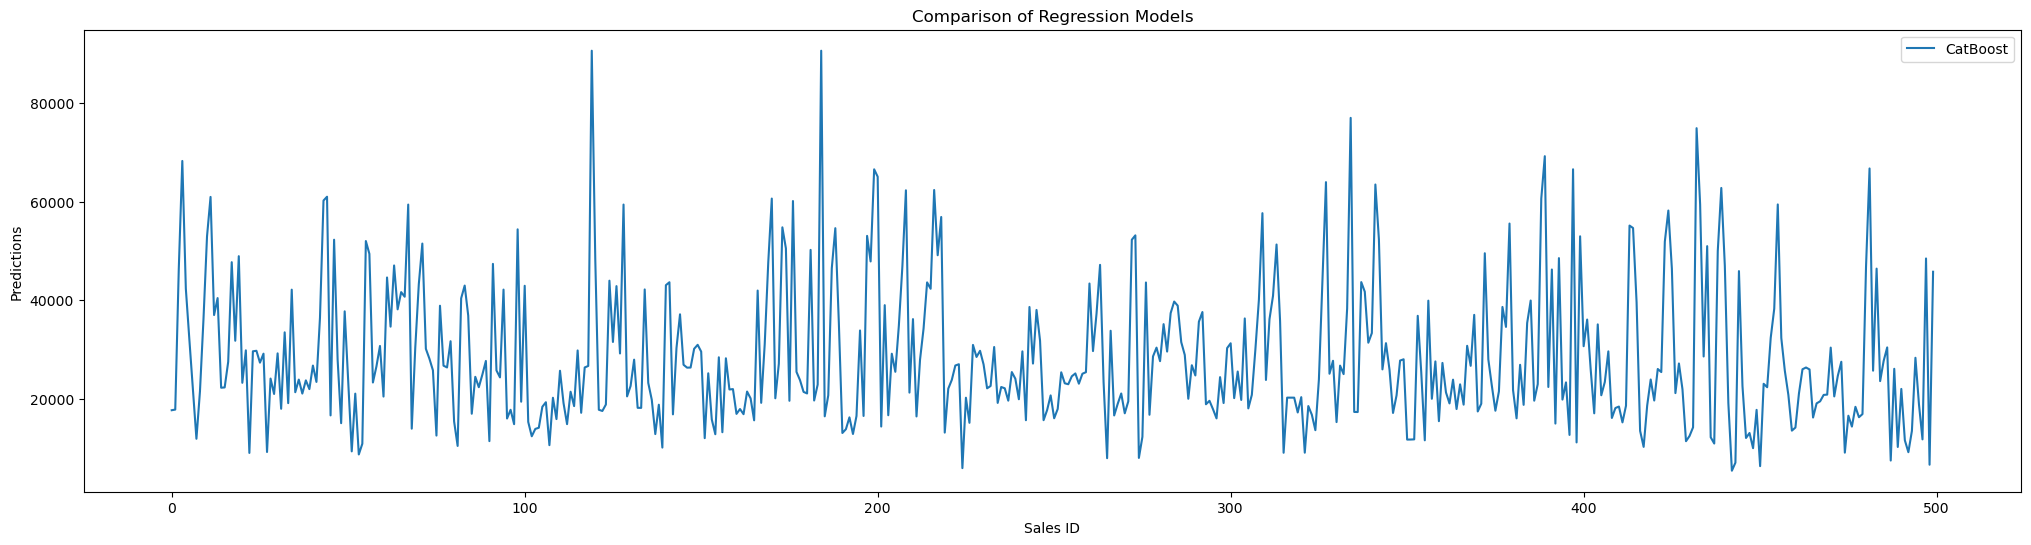

In [662]:
plt.figure(figsize=(25, 6))

x = np.arange(500)

plt.plot(x, df1['SalePrice(CatBoost)'][:500], label='CatBoost')



plt.xlabel('Sales ID')
plt.ylabel('Predictions')
plt.title('Comparison of Regression Models')

# Display the legend
plt.legend()

# Show the plot
plt.show()


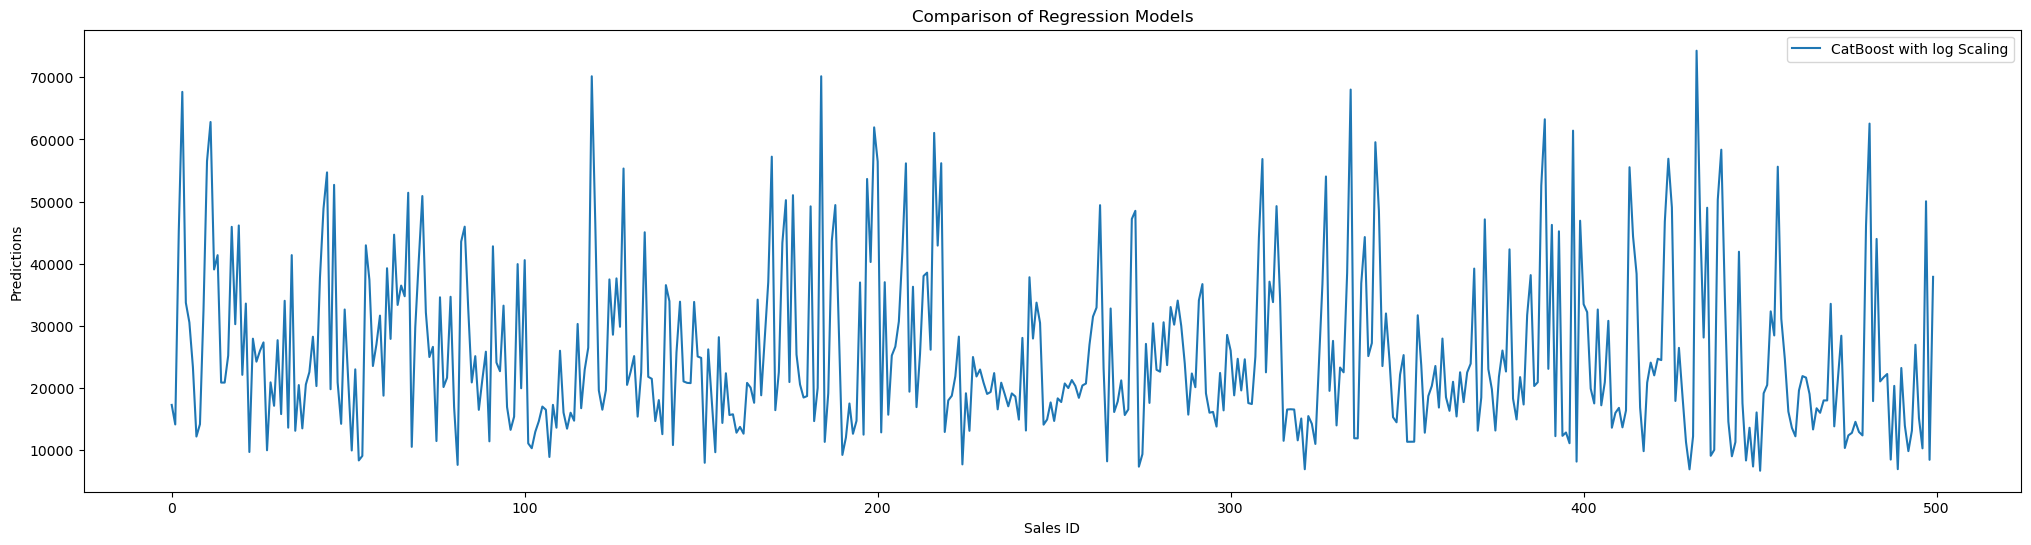

In [667]:


plt.figure(figsize=(25, 6))

x = np.arange(500)

plt.plot(x, df1['SalePrice(CatBoost with log Scaling)'][:500], label='CatBoost with log Scaling')



plt.xlabel('Sales ID')
plt.ylabel('Predictions')
plt.title('Comparison of Regression Models')

# Display the legend
plt.legend()

# Show the plot
plt.show()


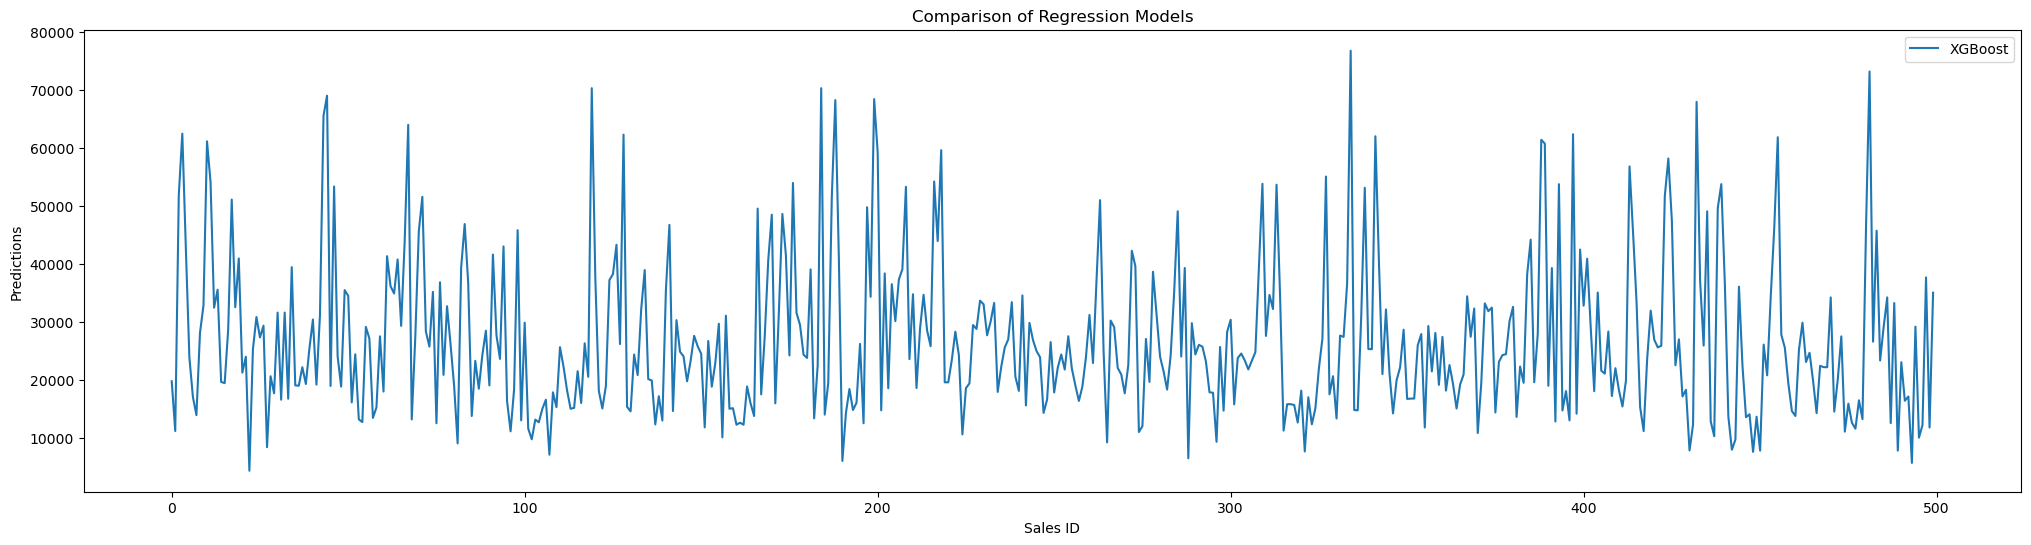

In [673]:


plt.figure(figsize=(25, 6))

x = np.arange(500)

plt.plot(x, df1['SalePrice(XGBoost)'][:500], label='XGBoost')


plt.xlabel('Sales ID')
plt.ylabel('Predictions')
plt.title('Comparison of Regression Models')

# Display the legend
plt.legend()

# Show the plot
plt.show()


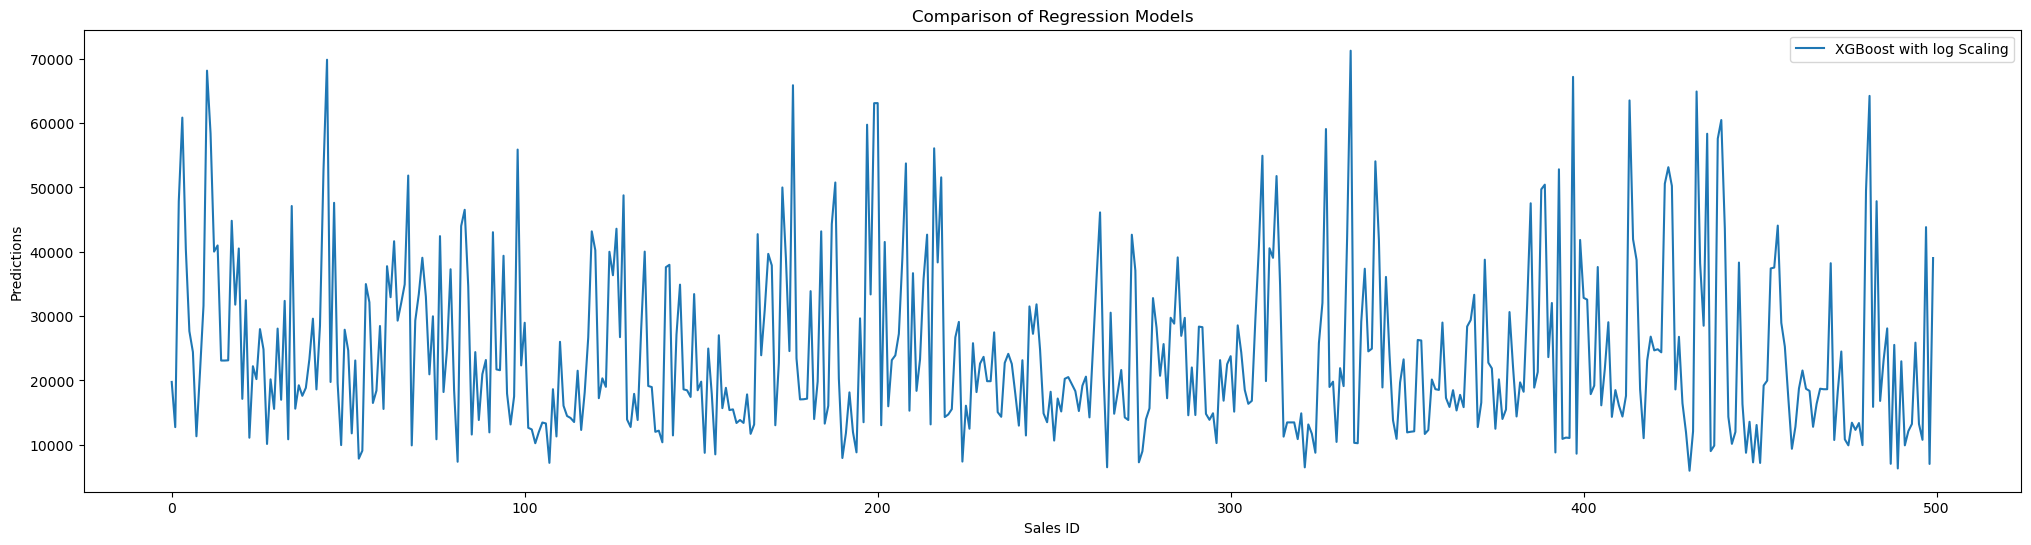

In [672]:


plt.figure(figsize=(25, 6))

x = np.arange(500)

plt.plot(x, df1['SalePrice(XGBoost with log Scaling)'][:500], label='XGBoost with log Scaling')

plt.xlabel('Sales ID')
plt.ylabel('Predictions')
plt.title('Comparison of Regression Models')

# Display the legend
plt.legend()

# Show the plot
plt.show()


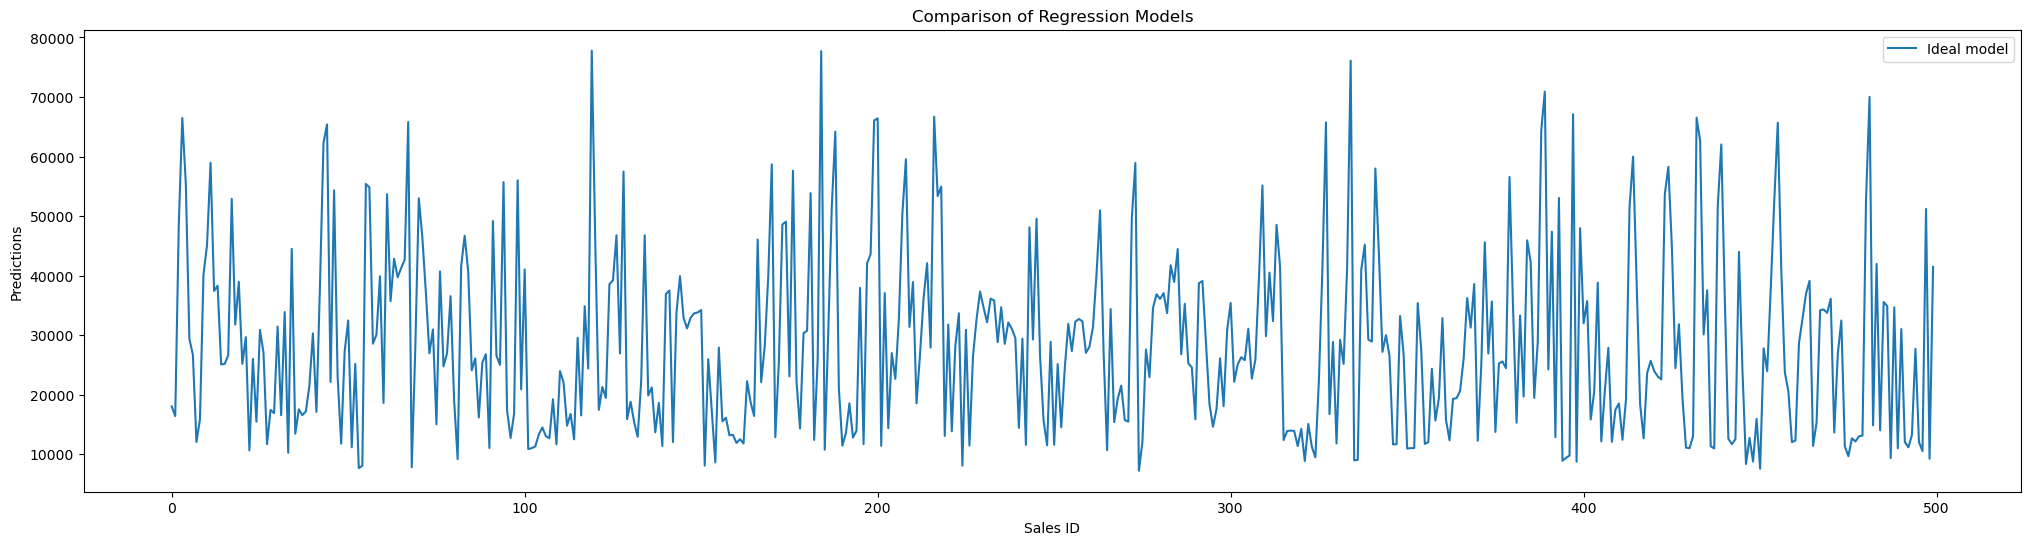

In [671]:


plt.figure(figsize=(25, 6))

x = np.arange(500)

plt.plot(x, df1['SalePrice(Ideal model)'][:500], label='Ideal model')


plt.xlabel('Sales ID')
plt.ylabel('Predictions')
plt.title('Comparison of Regression Models')

# Display the legend
plt.legend()

# Show the plot
plt.show()


### ***`THANK YOU :)`***